# 2. Contrast Adjustment

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

## 2.1. Histogram Equalization

**2.1.1. Write a program that can compute the histogram of a grayscale image (assuming 256 levels of gray). In a separate
main program, apply the program to Camera Man image, and illustrate the histogram as a stem plot besides the
test image (using “subplot” function).**

In [3]:
src_path = './Images/2/Camera Man.bmp'
src = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

In [4]:
def calculate_histogram(src):

    '''this function computes the histogram of a gray-scale image.'''

    height, width = src.shape
    src_flattened = src.flatten()
    num_pixels = len(src_flattened)
    intensities = np.linspace(start=0, stop=255, num=256, endpoint=True, dtype=int)
    
    frequencies = np.zeros(256, dtype=np.uint16)

    for i in range(num_pixels):
        frequencies[src_flattened[i]] += 1
    
    return intensities, frequencies

In [5]:
intensities, frequencies = calculate_histogram(src)

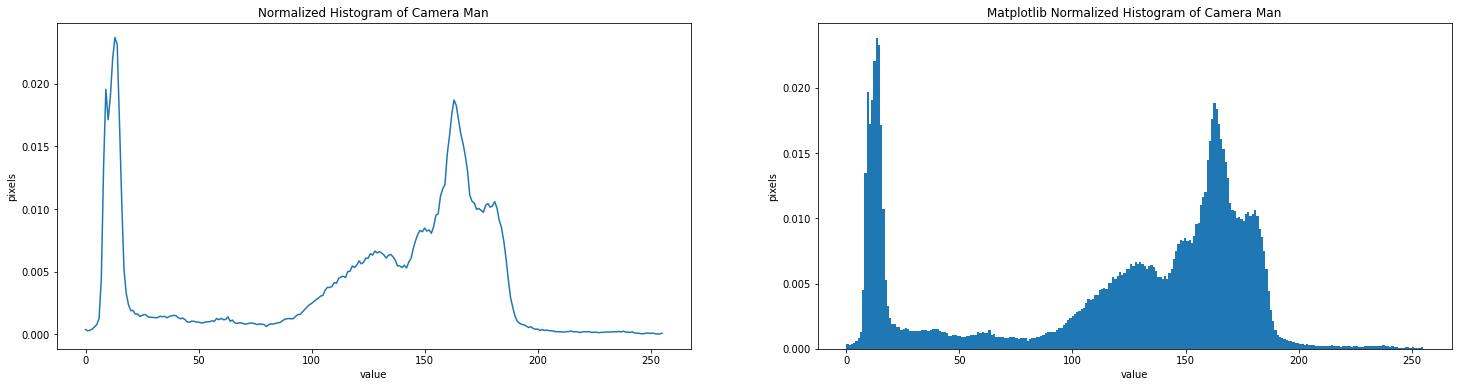

In [6]:
plt.figure(figsize=(25,6))
plt.subplot(1, 2, 1)
plt.plot(intensities, (frequencies / (len(src.flatten()))).ravel())
plt.title("Normalized Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")

plt.subplot(1, 2, 2)
plt.title("Matplotlib Normalized Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")
x, bins, p = plt.hist(src.flatten(), 256, density=True)

plt.show()

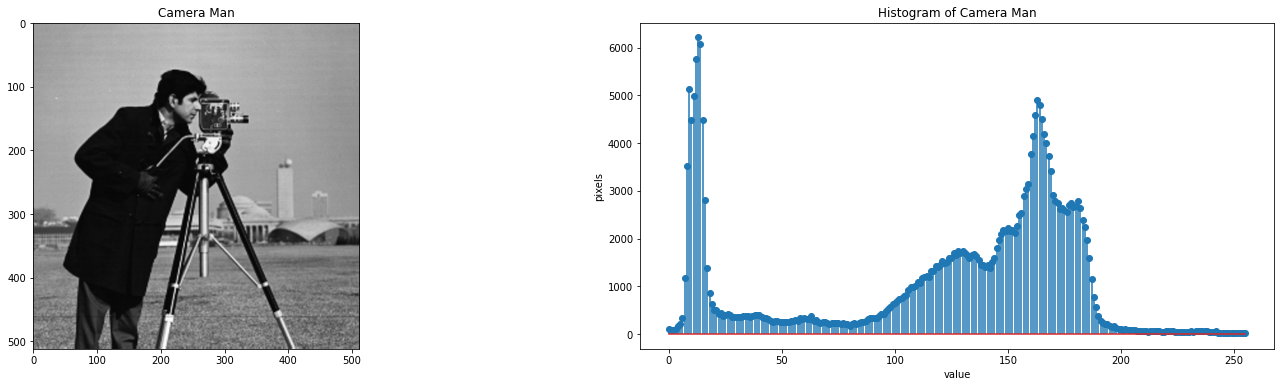

In [7]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("Camera Man")
plt.imshow(src, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, frequencies)
plt.title("Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

**2.1.2. Write a program that performs histogram equalization on Camera Man image. Display the original and equalized
images, as well as their corresponding histograms, all in one figure as mentioned in 2.1.1.**

In [8]:
def create_intensity_map(equalized_frequencies):
    intensity_map = {}
    for i in range(len(equalized_frequencies)):
        intensity_map[i] = equalized_frequencies[i]
        
    return intensity_map

In [9]:
def create_equalized_image(src, intensity_map):
    height, width = src.shape
    src_equalized = np.zeros_like(src)
    for i in range(height):
        for j in range(width):
            src_equalized[i,j] = intensity_map[src[i, j]]
    return src_equalized

In [10]:
def equalize_hist(src):
    intensities, frequencies = calculate_histogram(src)
    normalized_frequencies = frequencies / (len(src.flatten()))
    cumulative_sum_frequencies = np.cumsum(normalized_frequencies) * 255
    frequencies_equalized = np.array([round(cumulative_sum_frequencies[i]) for i in range(len(cumulative_sum_frequencies))])
    intensity_map = create_intensity_map(frequencies_equalized)
    src_equalized = create_equalized_image(src, intensity_map)
    return src_equalized

In [11]:
src_equalized = equalize_hist(src)

In [12]:
intensities, src_equalized_frequencies = calculate_histogram(src_equalized)

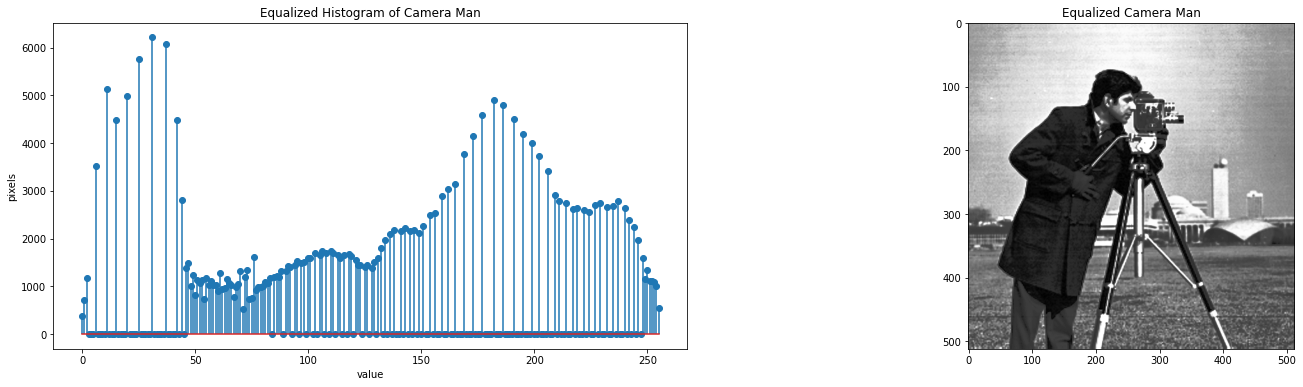

In [13]:
plt.figure(figsize=(25,6))
plt.subplot(1, 2, 1)
plt.stem(intensities, src_equalized_frequencies)
plt.title("Equalized Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")

plt.subplot(1, 2, 2)
plt.title("Equalized Camera Man")
plt.imshow(src_equalized, cmap='gray')

plt.show()

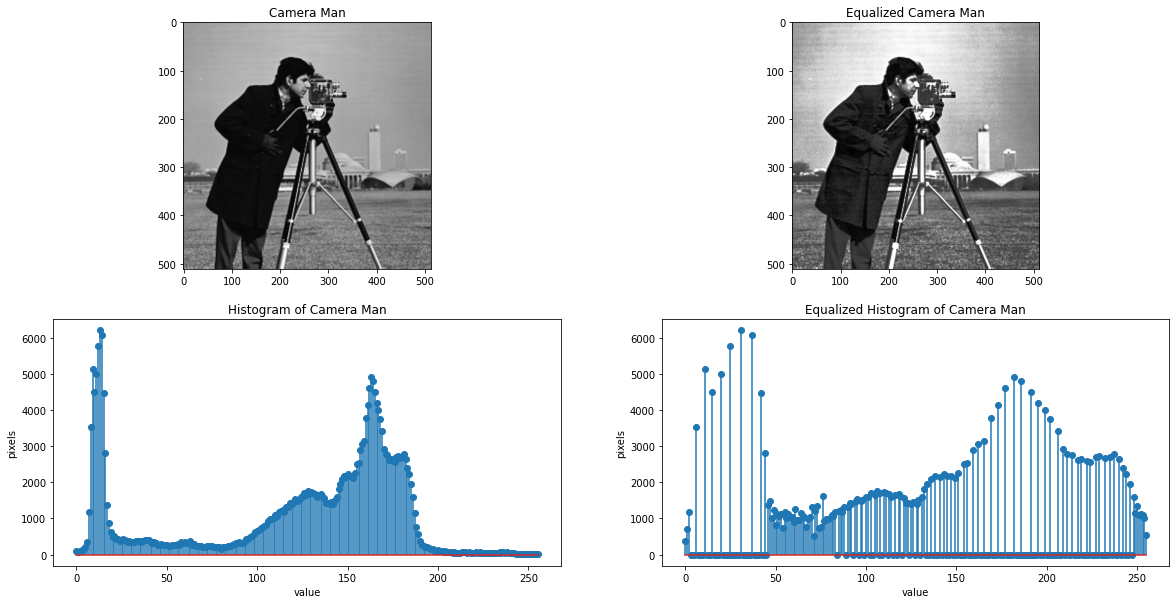

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title("Camera Man")
plt.imshow(src, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Equalized Camera Man")
plt.imshow(src_equalized, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")
plt.stem(intensities, frequencies)

plt.subplot(2, 2, 4)
plt.title("Equalized Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")
plt.stem(intensities, src_equalized_frequencies)

plt.show()

In [15]:
cv_src_equalized = cv2.equalizeHist(src)

In [16]:
intensities, cv_src_equalized_frequencies = calculate_histogram(cv_src_equalized)

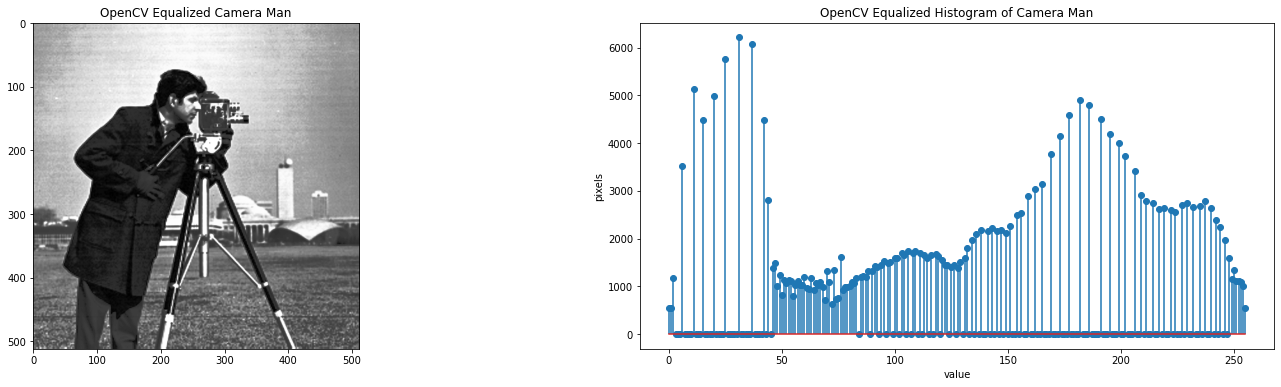

In [17]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("OpenCV Equalized Camera Man")
plt.imshow(cv_src_equalized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, cv_src_equalized_frequencies)
plt.title("OpenCV Equalized Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

In [18]:
def mse(A, B, ax=None):
    '''
    ax = 0: the average is performed along the row, for each column, returning an array
    ax = 1: the average is performed along the column, for each row, returning an array
    ax = None: the average is performed element-wise along the array, returning a scalar value
    '''
    return ((A - B)**2).mean(axis=ax)

In [19]:
print(mse(src_equalized, cv_src_equalized))

0.021694183349609375


**2.1.3. What is the difference between histeq and imadjust functions in Matlab? Play with these functions with various
input parameters for Camera Man image. Write down your observations in your report and display results.**

***Solution:***

***imadjust*** increases the contrast of the image by mapping the values of the input intensity image to new values such that, by default, 1% of the data is saturated at low and high intensities of the input data. imadjust linearly scales the histogram.

On the other hand, ***histeq*** performs histogram equalization. It enhances the contrast of images by transforming the values in an intensity image so that the histogram of the output image approximately matches a specified histogram (uniform distribution by default). histeq does not scale the histogram.

https://stackoverflow.com/questions/26818568/whats-the-difference-between-histeq-and-adapthisteq
https://www.mathworks.com/matlabcentral/answers/267371-what-is-the-difference-between-imadjust-and-histeq

In [19]:
import numpy as np
import bisect

def imadjust(src, tolerance=1, src_value_range=[0,255], dst_value_range=(0,255)):
    
    dst = src.copy()
    tolerance = max(0, min(100, tolerance))

    if tolerance > 0:
        # Compute in and out limits
        # Histogram
        hist = np.zeros(256, dtype=int)
        for r in range(src.shape[0]):
            for c in range(src.shape[1]):
                hist[src[r,c]] += 1
        
        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)):
            cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tolerance / 100
        upp_bound = total * (100 - tolerance) / 100
        src_value_range[0] = bisect.bisect_left(cum, low_bound)
        src_value_range[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (dst_value_range[1] - dst_value_range[0]) / (src_value_range[1] - src_value_range[0])
    for r in range(dst.shape[0]):
        for c in range(dst.shape[1]):
            vs = max(src[r,c] - src_value_range[0], 0)
            vd = min(int(vs * scale + 0.5) + dst_value_range[0], dst_value_range[1])
            dst[r,c] = vd
    return dst

In [20]:
src_adjusted = imadjust(src)

In [21]:
mse(cv_src_equalized, src_adjusted)

107.23188400268555

In [22]:
intensities, cv_src_equalized_frequencies = calculate_histogram(cv_src_equalized)
intensities, adjusted_src_equalized_frequencies = calculate_histogram(src_adjusted)

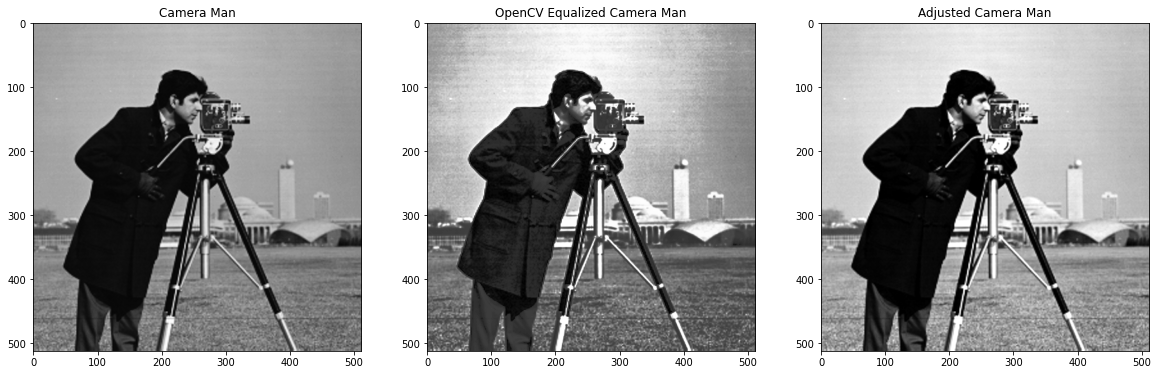

In [23]:
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
plt.title("Camera Man")
plt.imshow(src, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("OpenCV Equalized Camera Man")
plt.imshow(cv_src_equalized, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Adjusted Camera Man")
plt.imshow(src_adjusted, cmap='gray')

plt.show()

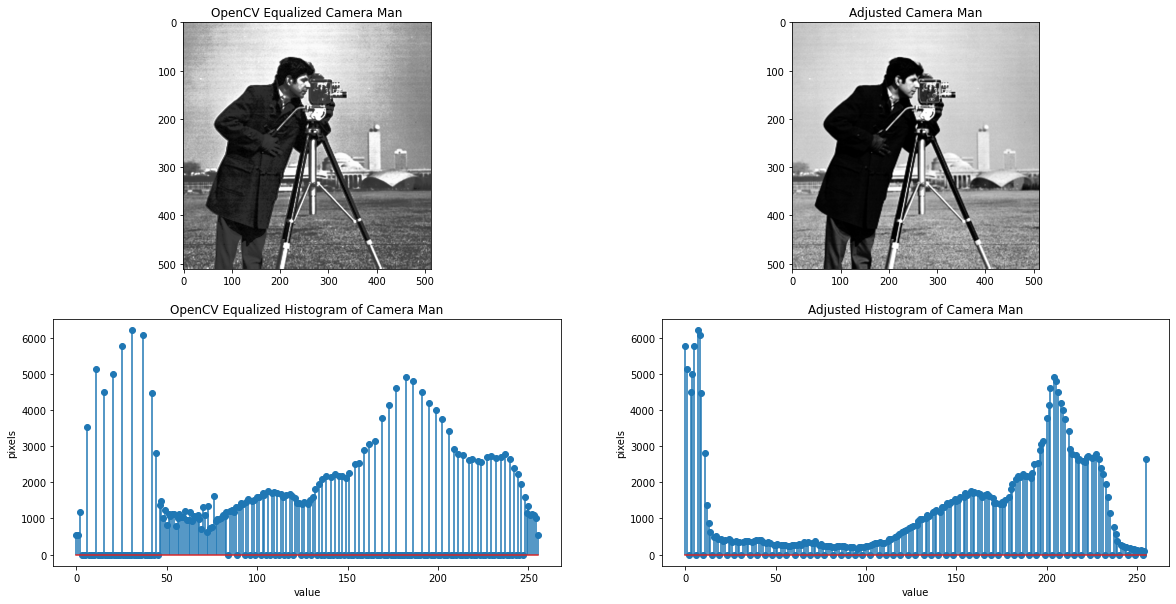

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title("OpenCV Equalized Camera Man")
plt.imshow(cv_src_equalized, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Adjusted Camera Man")
plt.imshow(src_adjusted, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("OpenCV Equalized Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")
plt.stem(intensities, cv_src_equalized_frequencies)

plt.subplot(2, 2, 4)
plt.title("Adjusted Histogram of Camera Man")
plt.xlabel("value")
plt.ylabel("pixels")
plt.stem(intensities, adjusted_src_equalized_frequencies)

plt.show()

## 2.2. Local Histogram Equalization

**2.2.1. Implement a local histogram equalization with different windows size for the HE1,2,3, and 4 images. Explain and
display the results. Discuss the effects of increasing window size and compare it with global histogram
equalization in detail.**

As we'll see in the examples, as the window size increases, the Local Histogram Equalization output will tend to the Global Histogram Equalization output.

In [25]:
def pad(src, window_size):
    return np.pad(src, ( (window_size // 2, window_size // 2), ( window_size // 2, window_size // 2) ) )

In [118]:
def equalize(region, window_size):
    his = cv2.calcHist([region],[0],None,[256],[0,256])
    cdf = his.cumsum()
    rounded = np.around(cdf[region] * (255 / (window_size * window_size) ) )
    center = rounded[( window_size // 2 ) + 1, ( window_size // 2 ) + 1]
    return center

In [117]:
def local_equalize_hist(src, window_size):
    height, width = src.shape
    src_padded = pad(src, window_size)

    dst = np.zeros_like(src)
    dst = [[ equalize(src_padded[i: i + window_size, j: j + window_size], window_size) for j in range(width)] for i in range(height)]
        
    return dst

In [28]:
he1_path = './Images/2/HE1.jpg'
he2_path = './Images/2/HE2.jpg'
he3_path = './Images/2/HE3.jpg'
he4_path = './Images/2/HE4.jpg'

he1 = cv2.imread(he1_path, cv2.IMREAD_GRAYSCALE)
he2 = cv2.imread(he2_path, cv2.IMREAD_GRAYSCALE)
he3 = cv2.imread(he3_path, cv2.IMREAD_GRAYSCALE)
he4 = cv2.imread(he4_path, cv2.IMREAD_GRAYSCALE)

In [63]:
he1_lhe_64 = local_equalize_hist(he1, 64)

In [71]:
he1_lhe_128 = local_equalize_hist(he1, 128)

In [88]:
he1_lhe_256 = local_equalize_hist(he1, 256)

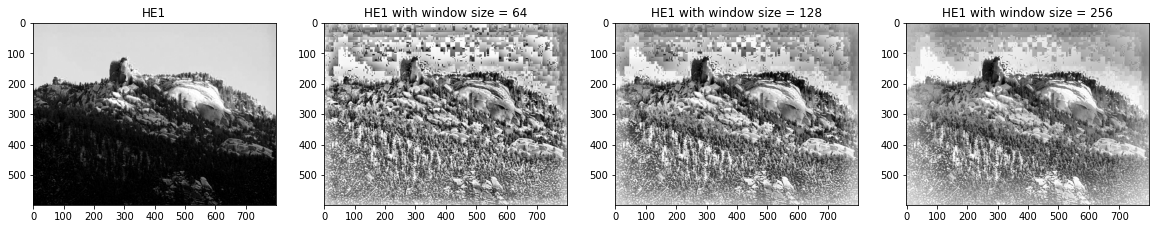

In [92]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE1")
plt.imshow(he1, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE1 with window size = 64")
plt.imshow(he1_lhe_64, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE1 with window size = 128")
plt.imshow(he1_lhe_128, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE1 with window size = 256")
plt.imshow(he1_lhe_256, cmap='gray')

In [64]:
he2_lhe_64 = local_equalize_hist(he2, 64)

In [72]:
he2_lhe_128 = local_equalize_hist(he2, 128)

In [89]:
he2_lhe_256 = local_equalize_hist(he2, 256)

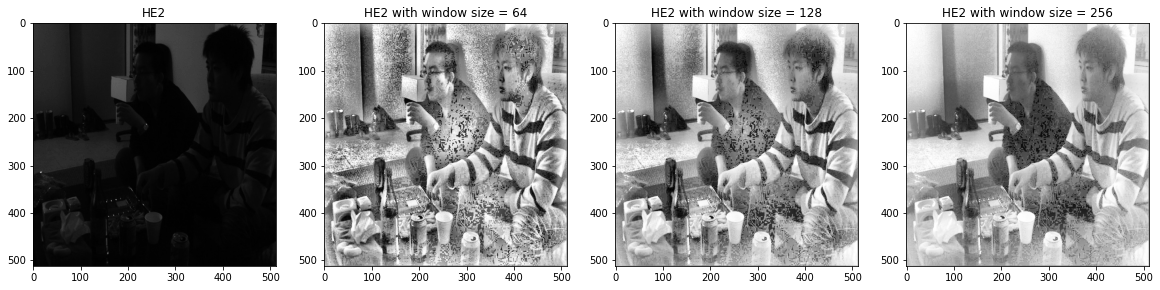

In [93]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE2")
plt.imshow(he2, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE2 with window size = 64")
plt.imshow(he2_lhe_64, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE2 with window size = 128")
plt.imshow(he2_lhe_128, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE2 with window size = 256")
plt.imshow(he2_lhe_256, cmap='gray')

In [65]:
he3_lhe_64 = local_equalize_hist(he3, 64)

In [73]:
he3_lhe_128 = local_equalize_hist(he3, 128)

In [90]:
he3_lhe_256 = local_equalize_hist(he3, 256)

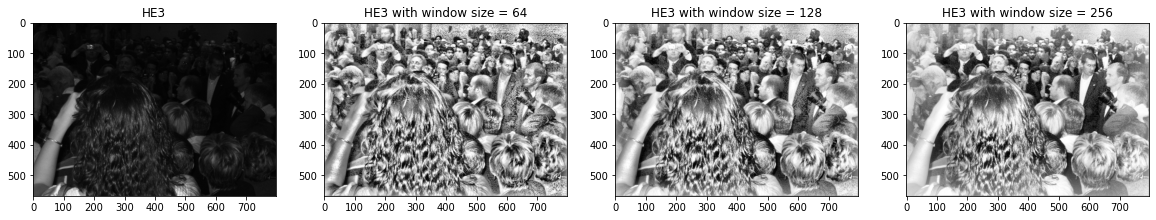

In [94]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE3")
plt.imshow(he3, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE3 with window size = 64")
plt.imshow(he3_lhe_64, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE3 with window size = 128")
plt.imshow(he3_lhe_128, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE3 with window size = 256")
plt.imshow(he3_lhe_256, cmap='gray')

In [66]:
he4_lhe_64 = local_equalize_hist(he4, 64)

In [74]:
he4_lhe_128 = local_equalize_hist(he4, 128)

In [91]:
he4_lhe_256 = local_equalize_hist(he4, 256)

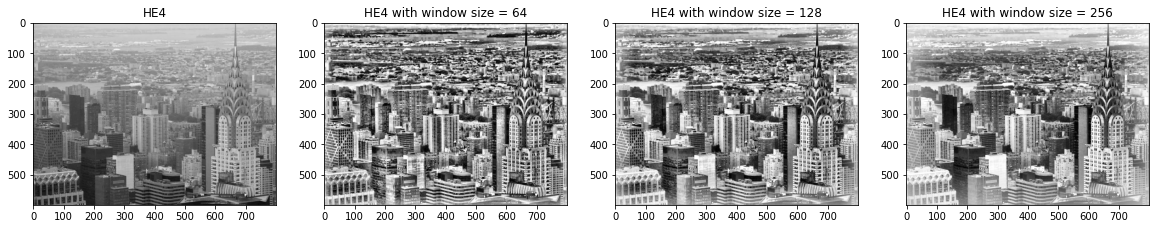

In [95]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE4")
plt.imshow(he4, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE4 with window size = 64")
plt.imshow(he4_lhe_64, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE4 with window size = 128")
plt.imshow(he4_lhe_128, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE4 with window size = 256")
plt.imshow(he4_lhe_256, cmap='gray')

In [86]:
cv2.imwrite('./Output Images/2/HE1_lhe_64.jpg', np.array(he1_lhe_64))
cv2.imwrite('./Output Images/2/HE2_lhe_64.jpg', np.array(he2_lhe_64))
cv2.imwrite('./Output Images/2/HE3_lhe_64.jpg', np.array(he3_lhe_64))
cv2.imwrite('./Output Images/2/HE4_lhe_64.jpg', np.array(he4_lhe_64))

True

In [87]:
cv2.imwrite('./Output Images/2/HE1_lhe_128.jpg', np.array(he1_lhe_128))
cv2.imwrite('./Output Images/2/HE2_lhe_128.jpg', np.array(he2_lhe_128))
cv2.imwrite('./Output Images/2/HE3_lhe_128.jpg', np.array(he3_lhe_128))
cv2.imwrite('./Output Images/2/HE4_lhe_128.jpg', np.array(he4_lhe_128))

True

In [96]:
cv2.imwrite('./Output Images/2/HE1_lhe_256.jpg', np.array(he1_lhe_256))
cv2.imwrite('./Output Images/2/HE2_lhe_256.jpg', np.array(he2_lhe_256))
cv2.imwrite('./Output Images/2/HE3_lhe_256.jpg', np.array(he3_lhe_256))
cv2.imwrite('./Output Images/2/HE4_lhe_256.jpg', np.array(he4_lhe_256))

True

In [101]:
he1_equalized = equalize_hist(he1)
he2_equalized = equalize_hist(he2)
he3_equalized = equalize_hist(he3)
he4_equalized = equalize_hist(he4)

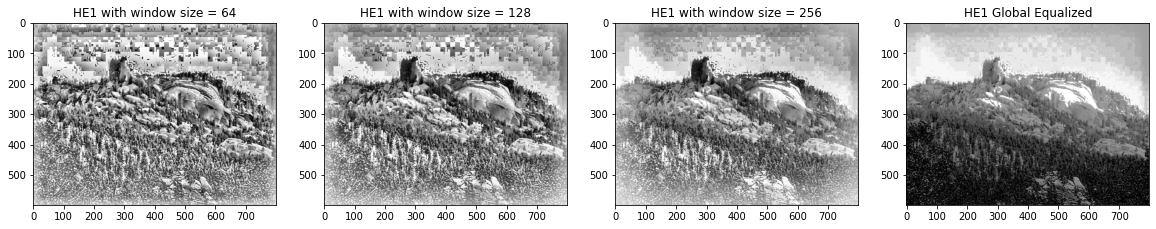

In [114]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE1 with window size = 64")
plt.imshow(he1_lhe_64, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE1 with window size = 128")
plt.imshow(he1_lhe_128, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE1 with window size = 256")
plt.imshow(he1_lhe_256, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE1 Global Equalized")
plt.imshow(he1_equalized, cmap='gray')

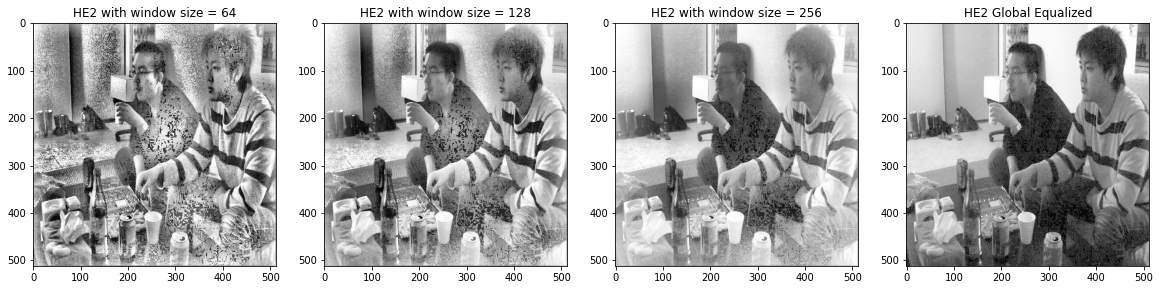

In [113]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE2 with window size = 64")
plt.imshow(he2_lhe_64, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE2 with window size = 128")
plt.imshow(he2_lhe_128, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE2 with window size = 256")
plt.imshow(he2_lhe_256, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE2 Global Equalized")
plt.imshow(he2_equalized, cmap='gray')

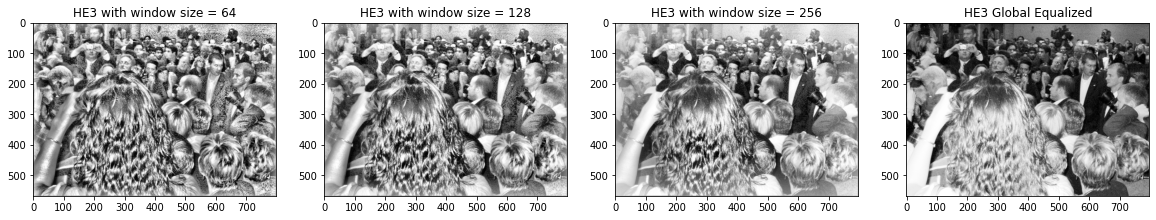

In [112]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE3 with window size = 64")
plt.imshow(he3_lhe_64, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE3 with window size = 128")
plt.imshow(he3_lhe_128, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE3 with window size = 256")
plt.imshow(he3_lhe_256, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE3 Global Equalized")
plt.imshow(he3_equalized, cmap='gray')

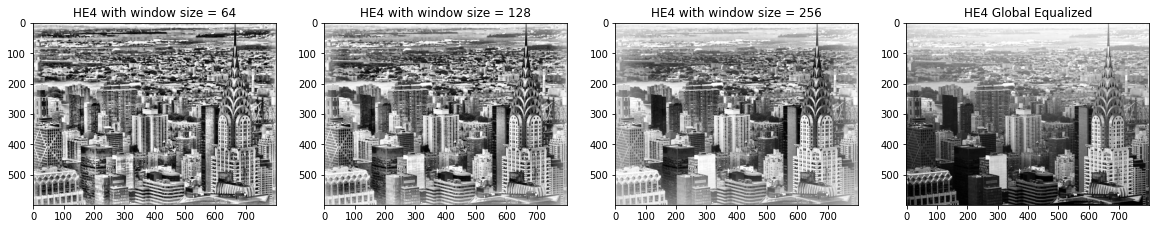

In [111]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("HE4 with window size = 64")
plt.imshow(he4_lhe_64, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("HE4 with window size = 128")
plt.imshow(he4_lhe_128, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("HE4 with window size = 256")
plt.imshow(he4_lhe_256, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("HE4 Global Equalized")
plt.imshow(he4_equalized, cmap='gray')

In [116]:
cv2.imwrite('./Output Images/2/HE1_global_equalized.jpg', he1_equalized)
cv2.imwrite('./Output Images/2/HE2_global_equalized.jpg', he2_equalized)
cv2.imwrite('./Output Images/2/HE3_global_equalized.jpg', he3_equalized)
cv2.imwrite('./Output Images/2/HE4_global_equalized.jpg', he4_equalized)

True

## Resources

1. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
2. https://www.tutorialspoint.com/how-to-normalize-a-histogram-in-python
3. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stem.html
4. https://www.geeksforgeeks.org/matplotlib-pyplot-stem-in-python/
5. https://www.w3schools.com/python/matplotlib_subplots.asp
6. https://stackoverflow.com/questions/3823752/display-image-as-grayscale-using-matplotlib
7. https://stackoverflow.com/questions/15889131/how-to-find-the-cumulative-sum-of-numbers-in-a-list
8. https://www.w3schools.com/python/ref_func_round.asp
9. https://docs.opencv.org/3.4.15/d4/d1b/tutorial_histogram_equalization.html
10. https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
11. https://github.com/mhdabbasi/Digital-Image-Processing-Gonzalez
12. https://opencv-tutorial.readthedocs.io/en/latest/histogram/histogram.html